In [2]:
import pandas as pd

In [6]:
features = pd.read_csv(r'https://media.githubusercontent.com/media/WillKoehrsen/Data-Analysis/master/random_forest_explained/data/temps.csv')
features.head()

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


### identify anomilies

In [7]:
features.shape

(348, 9)

In [8]:
features.describe()

,year,month,day,temp_2,temp_1,average,actual,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.511494,62.560345,59.760632,62.543103,60.034483
std,0.0,3.498380,8.772982,11.813019,11.767406,10.527306,11.794146,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,71.000000
max,2016.0,12.000000,31.000000,92.000000,92.000000,77.400000,92.000000,95.000000


In [13]:
# add dates
import datetime

dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day))
         for year, month, day in zip(features['year'], features['month'], features['day'])]

dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

C:\Users\lenovo\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\lenovo\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


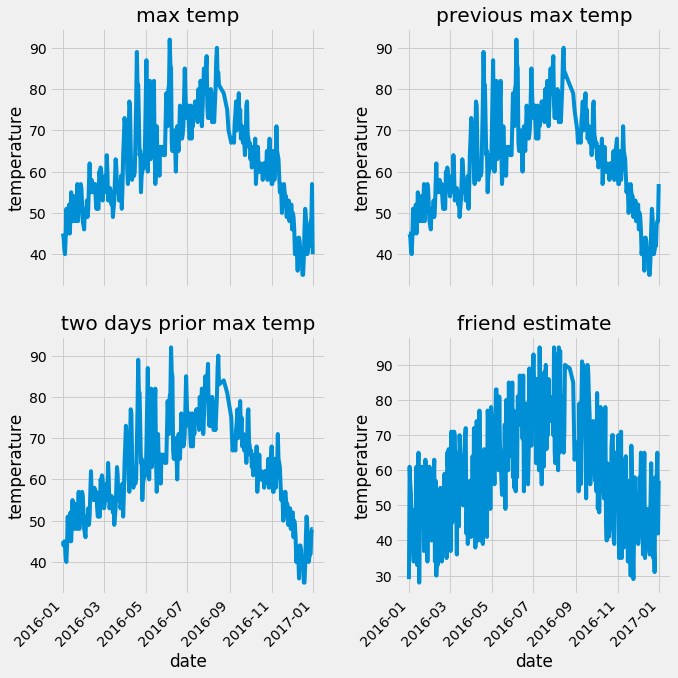

In [14]:
# plot
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('fivethirtyeight')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))
fig.autofmt_xdate(rotation = 45)

ax1.plot(dates, features['actual'])
ax1.set_xlabel('')
ax1.set_ylabel('temperature')
ax1.set_title('max temp')

# temperature from 1 day ago
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel('')
ax2.set_ylabel('temperature')
ax2.set_title('previous max temp')

# temperature from 2 days ago
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('date')
ax3.set_ylabel('temperature')
ax3.set_title('two days prior max temp')

# friend estimate
ax4.plot(dates, features['friend'])
ax4.set_xlabel('date')
ax4.set_ylabel('temperature')
ax4.set_title('friend estimate')

plt.tight_layout(pad = 2)

### one-hot encoding

In [15]:
features.dtypes

year         int64
month        int64
day          int64
week        object
temp_2       int64
temp_1       int64
average    float64
actual       int64
friend       int64
dtype: object

In [17]:
features = pd.get_dummies(features)
features.dtypes

year            int64
month           int64
day             int64
temp_2          int64
temp_1          int64
average       float64
actual          int64
friend          int64
week_Fri        uint8
week_Mon        uint8
week_Sat        uint8
week_Sun        uint8
week_Thurs      uint8
week_Tues       uint8
week_Wed        uint8
dtype: object

### x, y

In [18]:
import numpy as np

labels = np.array(features['actual'])
features = features.drop('actual', axis = 1)
features_list = list(features.columns)
features = np.array(features)

### training and testing sets

In [20]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                            test_size = 0.25,
                                                                            random_state = 42)
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
print(test_labels.shape)

(261, 14)
(261,)
(87, 14)
(87,)


### establish baseline (historical average)

In [24]:
print('average baseline error: ',
      round(np.mean(abs(test_features[:, features_list.index('average')] - test_labels)), 2),
      'degrees.')

average baseline error:  5.06 degrees.


### train model

In [25]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

### predict test data

In [26]:
predictions = rf.predict(test_features)

errors = abs(predictions - test_labels)

print('mean absolute error: ', round(np.mean(errors), 2), 'degrees.')

mean absolute error:  3.83 degrees.


### performance metrics: accuracy

In [27]:
mape = 100 * (errors / test_labels)
accuracy = 100 - np.mean(mape)
print('accuracy: ', round(accuracy, 2), '%.')

accuracy:  93.99 %.


### improve model if necessary

In [ ]:
rf_new = RandomForestRegressor(n_estimators = 100,
                               criterion = 'mse',
                               max_depth = None,
                               min_sample_split = 2,
                               min_samples_leaf = 1)

### interpret model results

In [32]:
# visualizing a single decision tree
from sklearn.tree import export_graphviz
import pydot

# pull out one tree
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = features_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
# graph.write_png('tree.png');

### variable importances

In [45]:
imp = pd.DataFrame(rf.feature_importances_, features_list).reset_index()
imp.columns = ['features', 'importances']
imp.sort_values('importances', ascending = False, inplace = True)
imp.reset_index(drop = True)

,features,importances
0,temp_1,0.698976
1,average,0.194227
2,day,0.025031
3,friend,0.024932
4,temp_2,0.023742
5,month,0.011121
6,week_Fri,0.004898
7,week_Sat,0.004163
8,week_Mon,0.002963
9,week_Sun,0.002885


### model with two most important features

In [56]:
rf_most_important = RandomForestRegressor(n_estimators = 1000,
                                          random_state = 42)

important_indices = [features_list.index('temp_1'), features_list.index('average')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

rf_most_important.fit(train_important, train_labels)
predictions = rf_most_important.predict(test_important)

errors = abs(predictions - test_labels)
print('mean absolute error: ', round(np.mean(errors), 2), 'degrees.')

mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape
print('accuracy: ', round(accuracy, 2), '%.')

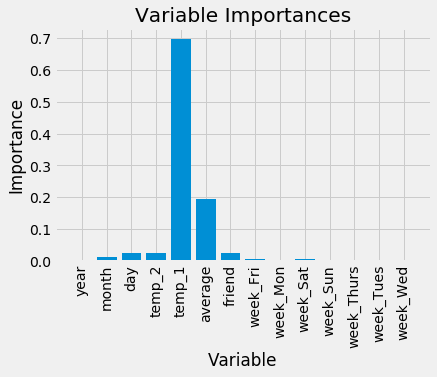

In [61]:
# visualizations
importances = list(rf.feature_importances_)
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, features_list, rotation = 'vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

### predictions and actual values

In [63]:
# Dates of training values
months = features[:, features_list.index('month')]
days = features[:, features_list.index('day')]
years = features[:, features_list.index('year')]

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

In [64]:
# Dates of predictions
months = test_features[:, features_list.index('month')]
days = test_features[:, features_list.index('day')]
years = test_features[:, features_list.index('year')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})

C:\Users\lenovo\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\lenovo\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\lenovo\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


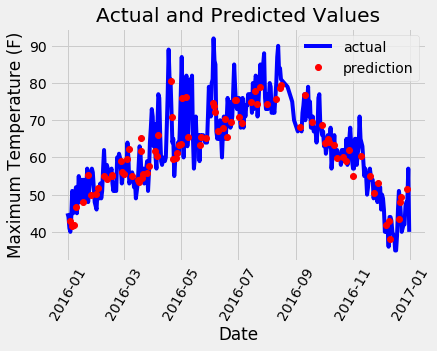

In [65]:
# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

### targets and data visualization

C:\Users\lenovo\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\lenovo\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\lenovo\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


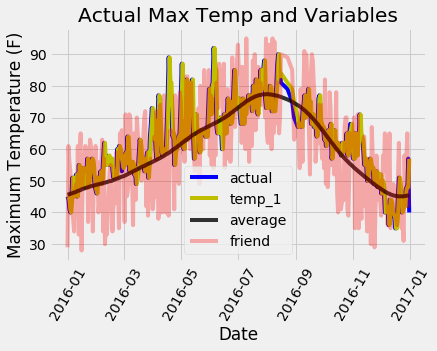

In [67]:
# Make the data accessible for plotting
true_data['temp_1'] = features[:, features_list.index('temp_1')]
true_data['average'] = features[:, features_list.index('average')]
true_data['friend'] = features[:, features_list.index('friend')]

# Plot all the data as lines
plt.plot(true_data['date'], true_data['actual'], 'b-', label  = 'actual', alpha = 1.0)
plt.plot(true_data['date'], true_data['temp_1'], 'y-', label  = 'temp_1', alpha = 1.0)
plt.plot(true_data['date'], true_data['average'], 'k-', label = 'average', alpha = 0.8)
plt.plot(true_data['date'], true_data['friend'], 'r-', label = 'friend', alpha = 0.3)

# Formatting plot
plt.legend(); plt.xticks(rotation = '60');

# Lables and title
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual Max Temp and Variables');

# improving

### using more data and choosing the most importance features

### three ways:
### More high-quality data
### Hyperparameter tuning of algorithm
### Try different algorithm

### more data

In [68]:
import pandas as pd

features = pd.read_csv('https://media.githubusercontent.com/media/WillKoehrsen/Data-Analysis/master/random_forest_explained/data/temps_extended.csv')
features.head()

,year,month,day,weekday,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,actual,friend
0,2011,1,1,Sat,4.92,0.00,0,36,37,45.6,40,40
1,2011,1,2,Sun,5.37,0.00,0,37,40,45.7,39,50
2,2011,1,3,Mon,6.26,0.00,0,40,39,45.8,42,42
3,2011,1,4,Tues,5.59,0.00,0,39,42,45.9,38,59
4,2011,1,5,Wed,3.80,0.03,0,42,38,46.0,45,39


In [69]:
print('we have {} days of data with {} variables.'.format(*features.shape))

we have 2191 days of data with 12 variables.


### visualization

In [70]:
round(features.describe(), 2)

,year,month,day,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,actual,friend
count,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00
mean,2013.50,6.52,15.71,7.37,0.12,0.01,61.17,61.18,60.29,61.18,60.31
std,1.71,3.45,8.80,3.15,0.25,0.15,13.09,13.08,10.73,13.08,15.87
min,2011.00,1.00,1.00,0.89,0.00,0.00,29.00,29.00,45.10,29.00,25.00
25%,2012.00,4.00,8.00,5.14,0.00,0.00,51.00,51.00,50.10,51.00,49.00
50%,2014.00,7.00,16.00,6.71,0.00,0.00,60.00,60.00,58.80,60.00,60.00
75%,2015.00,10.00,23.00,9.17,0.12,0.00,71.00,71.00,70.20,71.00,71.00
max,2017.00,12.00,31.00,21.25,2.20,3.00,96.00,96.00,77.40,96.00,97.00


C:\Users\lenovo\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\lenovo\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


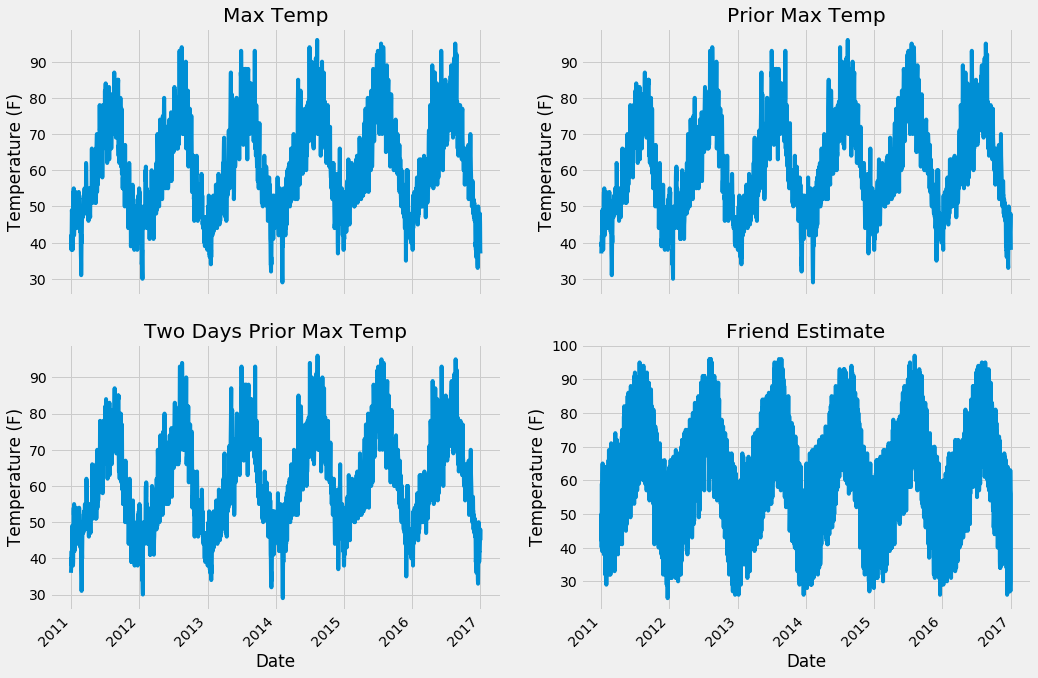

In [71]:
import datetime

years = features['year']
months = features['month']
days = features['day']

dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
fig.autofmt_xdate(rotation = 45)

# Actual max temperature measurement
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature (F)'); ax1.set_title('Max Temp')

# Temperature from 1 day ago
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature (F)'); ax2.set_title('Prior Max Temp')

# Temperature from 2 days ago
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature (F)'); ax3.set_title('Two Days Prior Max Temp')

# Friend Estimate
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature (F)'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

C:\Users\lenovo\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2064: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\lenovo\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


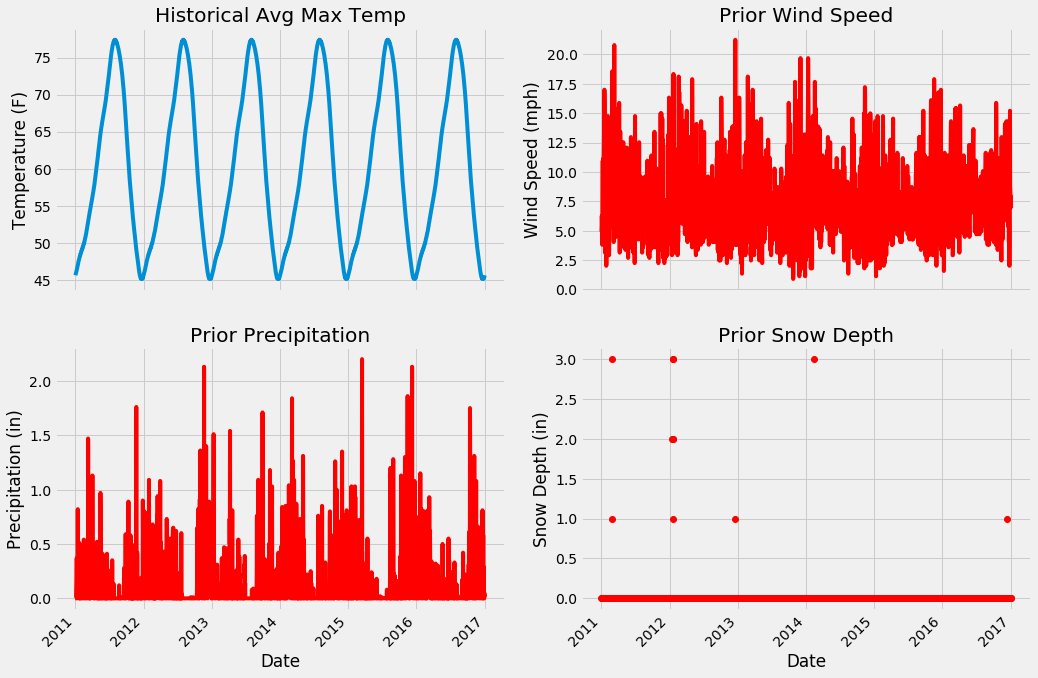

In [72]:
# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
fig.autofmt_xdate(rotation = 45)

# Historical Average Max Temp
ax1.plot(dates, features['average'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature (F)'); ax1.set_title('Historical Avg Max Temp')

# Prior Avg Wind Speed 
ax2.plot(dates, features['ws_1'], 'r-')
ax2.set_xlabel(''); ax2.set_ylabel('Wind Speed (mph)'); ax2.set_title('Prior Wind Speed')

# Prior Precipitation
ax3.plot(dates, features['prcp_1'], 'r-')
ax3.set_xlabel('Date'); ax3.set_ylabel('Precipitation (in)'); ax3.set_title('Prior Precipitation')

# Prior Snowdepth
ax4.plot(dates, features['snwd_1'], 'ro')
ax4.set_xlabel('Date'); ax4.set_ylabel('Snow Depth (in)'); ax4.set_title('Prior Snow Depth')

plt.tight_layout(pad=2)

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


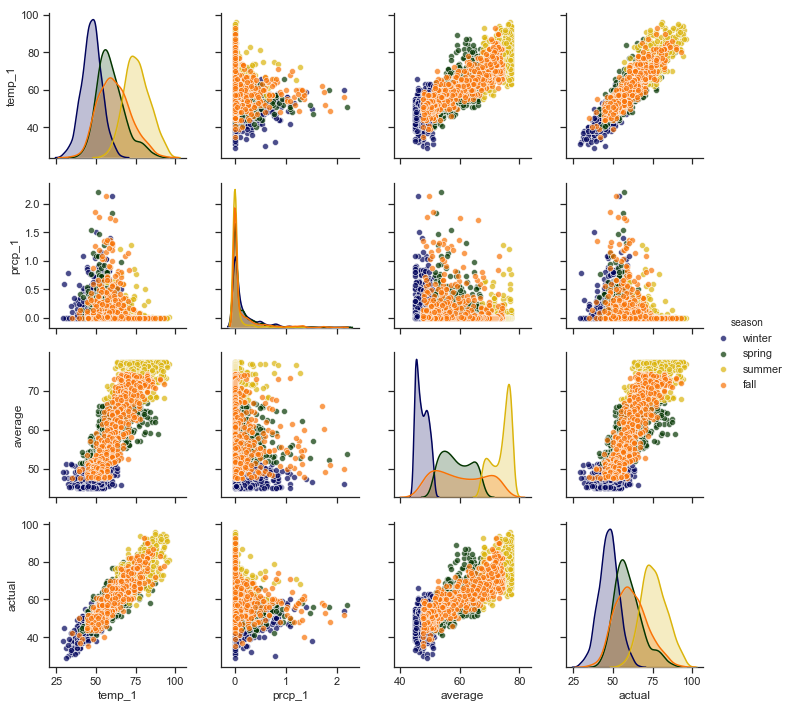

In [73]:
# pairplots: show relationship between variables in a dataset
# more correlated with max temperature would be more useful for prediction

# Create columns of seasons for pair plotting colors
seasons = []

for month in features['month']:
    if month in [1, 2, 12]:
        seasons.append('winter')
    elif month in [3, 4, 5]:
        seasons.append('spring')
    elif month in [6, 7, 8]:
        seasons.append('summer')
    elif month in [9, 10, 11]:
        seasons.append('fall')

# Will only use six variables for plotting pairs
reduced_features = features[['temp_1', 'prcp_1', 'average', 'actual']]
reduced_features['season'] = seasons

import seaborn as sns
sns.set(style="ticks", color_codes=True);

# Create a custom color palete
palette = sns.xkcd_palette(['dark blue', 'dark green', 'gold', 'orange'])

# Make the pair plot with a some aesthetic changes
sns.pairplot(reduced_features, hue = 'season', diag_kind = 'kde', palette= palette, plot_kws=dict(alpha = 0.7),
                   diag_kws=dict(shade=True));

### data preparation

In [74]:
# One Hot Encoding
features = pd.get_dummies(features)

# Extract features and labels
labels = features['actual']
features = features.drop('actual', axis = 1)

# List of features for later use
feature_list = list(features.columns)

# Convert to numpy arrays
import numpy as np

features = np.array(features)
labels = np.array(labels)

# Training and Testing Sets
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                            test_size = 0.25, random_state = 42)
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
# ....(the same)

Training Features Shape: (1643, 17)
Training Labels Shape: (1643,)
Testing Features Shape: (548, 17)
Testing Labels Shape: (548,)


In [ ]:
### feature reduction
# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)
# train again

### trade-off: time and accuracy

In [ ]:
import time

# All features training and testing time
all_features_time = []

# Do 10 iterations and take average for all features
for _ in range(10):
    start_time = time.time()
    rf_exp.fit(train_features, train_labels)
    all_features_predictions = rf_exp.predict(test_features)
    end_time = time.time()
    all_features_time.append(end_time - start_time)

all_features_time = np.mean(all_features_time)
print('All features total training and testing time:', round(all_features_time, 2), 'seconds.')

# Time training and testing for reduced feature set
reduced_features_time = []

# Do 10 iterations and take average
for _ in range(10):
    start_time = time.time()
    rf_exp.fit(important_train_features, train_labels)
    reduced_features_predictions = rf_exp.predict(important_test_features)
    end_time = time.time()
    reduced_features_time.append(end_time - start_time)

reduced_features_time = np.mean(reduced_features_time)
print('Reduced features total training and testing time:', round(reduced_features_time, 2), 'seconds.')

# almost 40% time reduced and basically same accuracy

# improving
### less features with cv & grid_search

In [75]:
# Names of five importances accounting for 95% of total importance
important_feature_names = ['temp_1', 'average', 'ws_1', 'temp_2', 'friend', 'year']

# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]

# Create training and testing sets with only the important features
important_train_features = train_features[:, important_indices]
important_test_features = test_features[:, important_indices]

# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

Important train features shape: (1643, 6)
Important test features shape: (548, 6)


In [76]:
# Use only the most important features
train_features = important_train_features[:]
test_features = important_test_features[:]

# Update feature list for visualizations
feature_list = important_feature_names[:]

### Examine the Default Random Forest to Determine Parameters

In [77]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 42)

from pprint import pprint
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


### random search with cross validation

In [80]:
from sklearn.model_selection import RandomizedSearchCV

# trees
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# number of features to consider at every split
max_features = ['auto', 'sqrt']
# maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# minimum number of samples required to split a node
min_sample_split = [2, 5, 10]
# minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# method of selecting samples for training each tree
bootstrap = [True, False]

random_grid = {'n_estimators':n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_sample_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [88]:
rf_random = RandomizedSearchCV(estimator = RandomForestRegressor(), 
                               param_distributions = random_grid,
                               n_iter = 100,  # 100 combinations
                               scoring = 'neg_mean_absolute_error',
                               cv = 3, 
                               verbose = 2,
                               random_state = 42,
                               n_jobs = -1)

In [ ]:
# rf_random.fit(train_features, train_labels)

### evaluation

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

In [ ]:
base_model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
base_model.fit(train_features, train_labels)
evaluate(base_model, test_features, test_labels)

In [ ]:
best_random = rf_random.best_estimator_
evaluate(best_random, test_features, test_labels)

### grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

grid_search = GridSearchCV(estimator = RandomForestRegressor(),
                           param_grid = param_grid,
                           scoring = 'neg_mean_absolute_error',
                           cv = 3,
                           n_job = -1,
                           verbose = 2)

grid_search.fit(train_features, train_labels)
grid_search.best_params_
best_grid = grid_search.best_estimator_
evaluate(best_grid, test_features, test_labels)

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [110, 120, None],
    'max_features': [3, 4],
    'min_samples_leaf': [5, 6, 7],
    'min_samples_split': [10],
    'n_estimators': [75, 100, 125]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search_ad = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           scoring = 'neg_mean_absolute_error', cv = 3, 
                           n_jobs = -1, verbose = 2)

grid_search_ad.fit(train_features, train_labels)
# ...same

### final model

In [ ]:
print('Model Parameters:\n')
pprint(best_grid.get_params())
print('\n')
evaluate(best_grid, test_features, test_labels)